# Planning a telescope observation

I want to know how likely it is that tomorrow night will be clear given the weather tonight (clear or cloudy). The key piece of information here is that the weather tomorrow depends on the weather today. From past history, you know that:
<center> $p(clear \ tomorrow \ | \ cloudy \ today) = 0.5 ,$ </center>
which means that 
<center> $p(cloudy \ tomorrow \ | \ cloudy \ today) = 0.5 .$ </center>
We also have
<center> $p(cloudy \ tomorrow \ | \ clear \ today) = 0.1 ,$ </center>
which means that
<center> $p(clear \ tomorrow \ | \ clear \ today) = 0.9 .$ </center>

- We can start with the sky conditions today and make predictions going forward more and more into the future.
- This will look like a big decision tree.
- After enough days, we'll reach equilibrium probabilities that have to do with the mean weather statistics (ignoring seasons) and we'll arrive at
<center> $p(clear) = 0.83,$ </center>
and
<center> $p(clear) = 0.17.$ </center>

I get the same answer for day $N$ as day $N+1$ and it doesn't matter whether it was clear or cloudy on the day that i started. The steps that i have taken in this process are, indeed, a $\textbf{MARKOV CHAIN}$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import uniform
from astropy.visualization.hist import hist as fancyhist
from sklearn.mixture import GaussianMixture
import random
from tqdm import tqdm
from scipy.stats import norm
import astroML.stats

plt.rcParams['figure.figsize'] = [10, 8]

Legend:  
- 1 = clear  
- 0 = cloudy

I start off on a cloudy day.  
I implement my weather forecast based on the above probabilities, and i run my simulator for $N = 10^4$ days

In [11]:
N = 10000
cond = np.zeros(N)

i = 0
while i != N-1:
    prob = uniform.rvs()
    if cond[i] == 1:
        if prob <= 0.9:
            cond[i+1] = 1
        else:
            cond[i+1] = 0
    elif cond[i] == 0:
        if prob <= 0.5:
            cond[i+1] = 1
        else:
            cond[i+1] = 0
    i += 1

In [12]:
sunny = 0
sunny_days = []
cloudy = 0
for pi in cond:
    if pi == 1:
        sunny += 1
    else:
        cloudy += 1
        
prob_sunny = sunny / N
prob_cloudy = cloudy / N
print('Probability to have a sunny day: ' + str(prob_sunny*100) + '%')
print('Probability to have a cloudy day: ' + str(prob_cloudy*100) + '%')

Probability to have a sunny day: 82.43%
Probability to have a cloudy day: 17.57%


I prepare a plot with the number of days on the x axis and the cumulative fraction of sunny days over the number of days so far on the y axis.  
This is called a $\textbf{trace-plot}$, which shows my estimate of $p(clear)$ evolves as the chain samples.

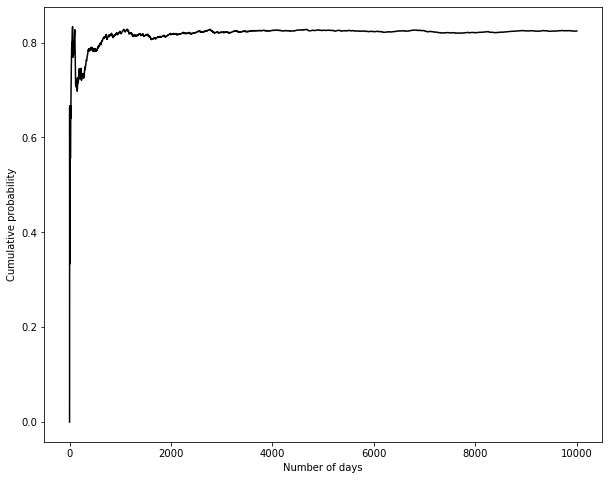

In [13]:
cumulative_sunny_days = [0] * N
cumulative_sum = 0
for i in range(N):
    cumulative_sum = cumulative_sum + cond[i]
    cumulative_sunny_days[i] = cumulative_sum / (i+1)

plt.plot(cumulative_sunny_days, '-k')
plt.xlabel('Number of days')
plt.ylabel('Cumulative probability');

I prepare an histogram of the above plot, which reveals the distribution of $p(clear)$.

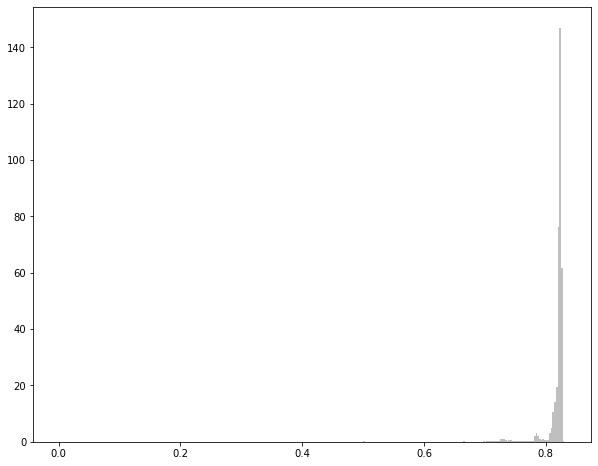

In [14]:
plt.hist(cumulative_sunny_days, bins=300, alpha=0.5, density=True, color='grey');

Through a summary statistic i determine the most likely value and an error my our estimate.

In [15]:
print('The median of the cumulative sum of sunny days is %f +- %f' %(np.median(cumulative_sunny_days), astroML.stats.sigmaG(cumulative_sunny_days)))

The median of the cumulative sum of sunny days is 0.823098 +- 0.003213


$\textbf{Important}$:  
In MCMC the process must be stationary which means that the chain statistics looks the same no matter which chunk i look at!  
This isn't going to be the case in the early step of the chain. In this example, after some time the process was stationary , but not in the first few days.  
So there is a $\textbf{burn-in}$ phase that needs to be discarded. How one determines the number of early steps to discard as burn-in is tricky, so i $\textit{start with a traceplot of my samples!}$

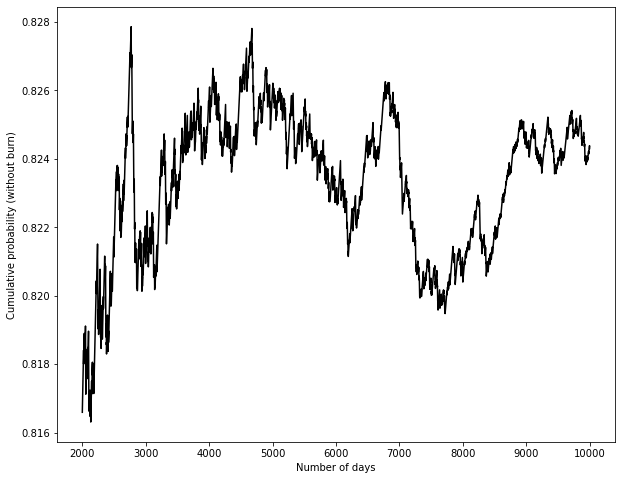

In [16]:
# i need to remove the "burn" points
burn = 2000
xplot = np.linspace(burn, N, len(cumulative_sunny_days[burn:]))
plt.plot(xplot, cumulative_sunny_days[burn:], color='black')
plt.xlabel('Number of days')
plt.ylabel('Cumulative probability (without burn)');

0.823950823202904
0.0022781341117582444
0.8163074039362699 0.8278599783471671


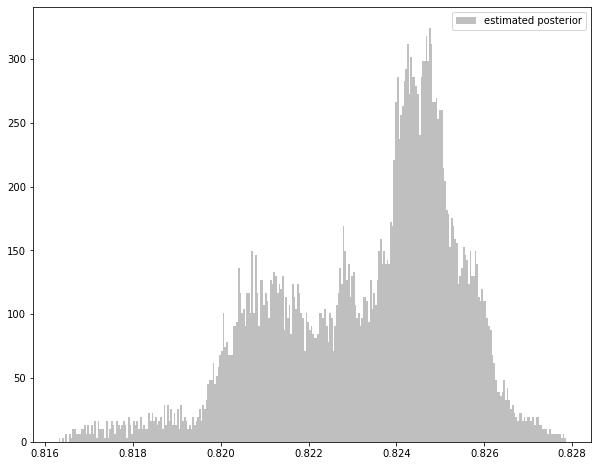

In [18]:
print(np.median(cumulative_sunny_days[burn:]))
print(astroML.stats.sigmaG(cumulative_sunny_days[burn:]))
print(min(cumulative_sunny_days[burn:]),max(cumulative_sunny_days[burn:]))
ax = plt.subplot()
ax.hist(cumulative_sunny_days[burn:], bins=300, alpha=0.5, color='grey',
        density=True, label='estimated posterior')
ax.legend(fontsize=10);

A markov chain can also be applied on ***stock market***, which has phases of growing prices (bull), dreasing prices (bear) and recession (stagnant).

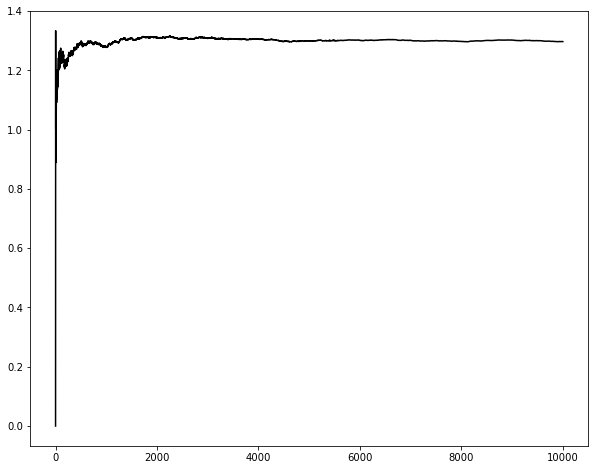

In [26]:
market = [0] # 0 -> bull, 1 -> bear, 2 -> stagnant

for ii in range(1,10000):
    # implementing forecasts based on probabilities
    if market[ii-1] == 0:
        market.append(np.random.choice(np.array([0, 2]), p=np.array([0.1, 0.9])))
    elif market[ii-1] == 1:
        market.append(np.random.choice(np.array([0, 2]), p=np.array([0.2, 0.8])))
    elif market[ii-1] == 2:
        market.append(np.random.choice(np.array([0, 2]), p=np.array([0.5, 0.5])))
        
market = np.array(market)

cumulative_bull_market = np.cumsum(market)/( np.arange(market.shape[0])+1 )
# plot the running average
plt.plot(cumulative_bull_market, '-k')

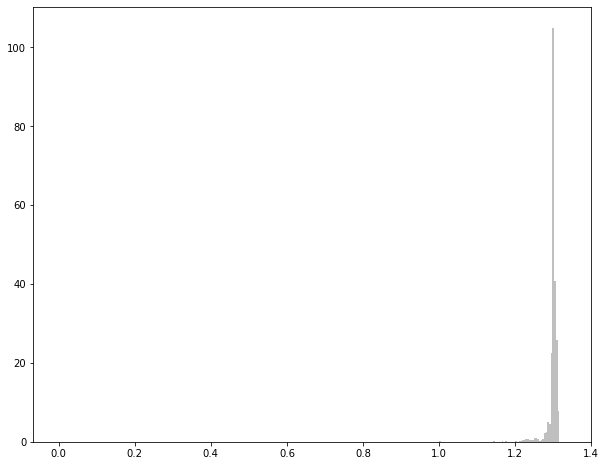

In [27]:
plt.hist(cumulative_bull_market, bins=300, alpha=0.5, density=True, color='grey');

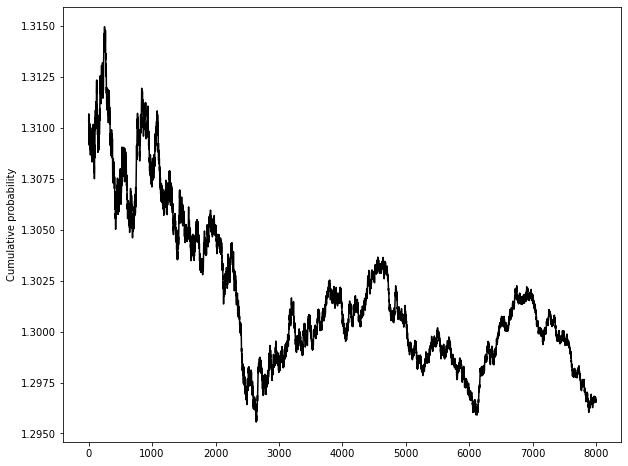

In [31]:
# i need to remove the "burn" points
burn = 2000
xplot = np.linspace(burn, 1e4, len(cumulative_bull_market[burn:]))
plt.plot(cumulative_bull_market[burn:], '-k')
plt.ylabel('Cumulative probability');

1.300707462050331
0.003681366237352947
1.2955622576475656 1.3149711239449133


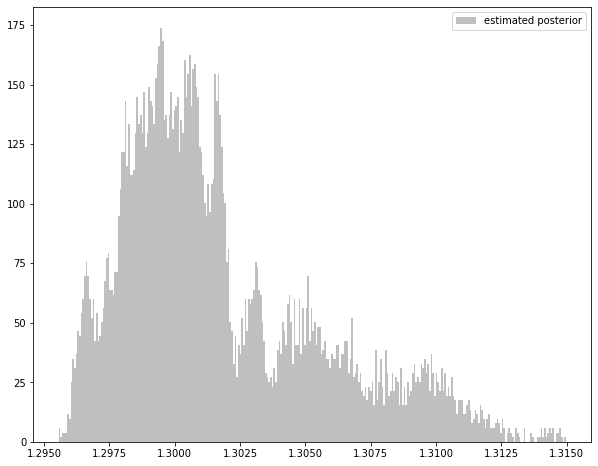

In [32]:
print(np.median(cumulative_bull_market[burn:]))
print(astroML.stats.sigmaG(cumulative_bull_market[burn:]))
print(min(cumulative_bull_market[burn:]),max(cumulative_bull_market[burn:]))
ax = plt.subplot()
ax.hist(cumulative_bull_market[burn:], bins=300, alpha=0.5, color='grey',
        density=True, label='estimated posterior')
ax.legend(fontsize=10);